In [1]:
import os
import boto3

import pandas as pd
import numpy as np

from sagemaker.session import Session

In [2]:
# asset classification for in/out of network
in_network_asset = ['Collateralized short-term financing agreements', 'Deposits with clearing organizations', 
                    'Receivable from broker-dealers', 'Receivable from parent and affiliates', 
                    'Receivables from customers and counterparties']

out_network_asset = ['Cash and cash equivalents', 'Cash and securities segregated for benefit of customers or regulations',
                     'Exchange memberships', 'Fixed assets', 'Intangible assets, net amortization', 
                     'PPE (net depreciation & amortization)', 'Receivable from employees', 'Time bank deposits',
                     'Deferred tax asset']

fifty_network_asset = ['Account receivable', 'Escrow account balances', 'Other assets', 'Other receivables', 
                       'Prepaid expenses']

special_network_asset = ['Financial instruments owned, at fair value', 'U.S. government and government agency']

# liability & equity classification for in/out of network 
in_network_liable = ['Collateralized borrowing agreements', 'Financial instruments sold,  but not yet purchased at fair value',
                     'Payable to banks', 'Payable to broker-dealers', 'Payable to customers and counterparties',
                     'Payable to parent and affiliates']

out_network_liable = ['Deferred liability', 'Lease liability', 'Taxes payable']

fifty_network_liable = ['Accounts payable', 'Accrued liabilities', 'Current liabilities', 'Long-term borrowing',
                        'Other liabilities', 'Short-term borrowing', 'Subordinated liabilities']


In [53]:
# Amazon Textract client and Sagemaker session
s3 = boto3.client('s3')
session = Session()

bucket = 'ran-s3-systemic-risk'

# retrieving the asset and liability classification models from s3 bucket
s3.download_file(bucket, 'Output/structured_asset.csv', 'structured_asset.csv')
df1 = pd.read_csv('structured_asset.csv')
os.remove('structured_asset.csv')

s3.download_file(bucket, 'Output/structured_liability.csv', 'structured_liability.csv')
df2 = pd.read_csv('structured_liability.csv')
os.remove('structured_liability.csv')

# retrieving the in/out classification for the financial markets split  
s3.download_file(bucket, 'Temp/dealers_perc_in_ffunds.csv', 'dealers_perc_in_ffunds.csv')
df3 = pd.read_csv('dealers_perc_in_ffunds.csv')
df3 = df3.iloc[3::4]
df3['Date'] = df3['Date'].apply(lambda x: pd.to_datetime(x).year)
os.remove('dealers_perc_in_ffunds.csv')

In [54]:
df3

,Date,share_sec_in
3,2000,0.126583
7,2001,0.134754
11,2002,0.148449
15,2003,0.140575
19,2004,0.140413
23,2005,0.169508
27,2006,0.164217
31,2007,0.155410
35,2008,0.089199
39,2009,0.103416


In [59]:
from scipy.stats import linregress

In [60]:
f = linregress(df3.Date, df3.share_sec_in)
g = lambda x: f.slope * x + f.intercept

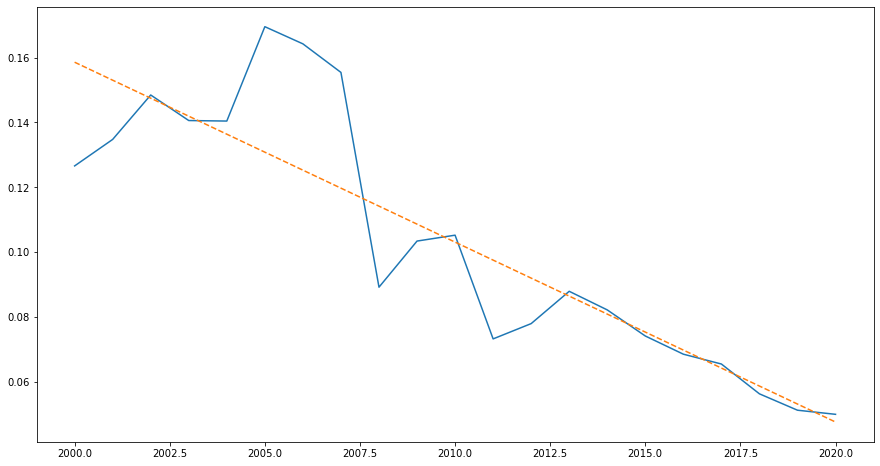

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.plot(df3.Date, df3.share_sec_in)
plt.plot(df3.Date, g(df3.Date), ls='--')
plt.show()

In [5]:
# determing the in/out network assets and liability & equity terms 
df1['IN_NETWORK_ASSETS'] = df1[df1.columns[np.isin(df1.columns, in_network_asset)]].sum(axis=1) + (df1[df1.columns[np.isin(df1.columns, fifty_network_asset)]].sum(axis=1) * 0.5)
df1['OUT_NETWORK_ASSETS'] = df1[df1.columns[np.isin(df1.columns, out_network_asset)]].sum(axis=1) + (df1[df1.columns[np.isin(df1.columns, fifty_network_asset)]].sum(axis=1) * 0.5)

df2['IN_NETWORK_LIABLE'] = df2[df2.columns[np.isin(df2.columns, in_network_liable)]].sum(axis=1) + (df2[df2.columns[np.isin(df2.columns, fifty_network_liable)]].sum(axis=1) * 0.5)
df2['OUT_NETWORK_LIABLE'] = df2[df2.columns[np.isin(df2.columns, out_network_liable)]].sum(axis=1) + (df2[df2.columns[np.isin(df2.columns, fifty_network_liable)]].sum(axis=1) * 0.5)

In [6]:
# select subsmaple for columsn to report back and merge
a = df1[['CIK', 'Name', 'Filing Date', 'Filing Year', 'IN_NETWORK_ASSETS', 'OUT_NETWORK_ASSETS']]
b = df2[['CIK', 'Name', 'Filing Date', 'Filing Year', 'IN_NETWORK_LIABLE', 'OUT_NETWORK_LIABLE']]

In [11]:
# merge the liability and equity dataframe with the asset dataframe 
c = pd.merge(a, b, on=['CIK', 'Name', 'Filing Date', 'Filing Year'])

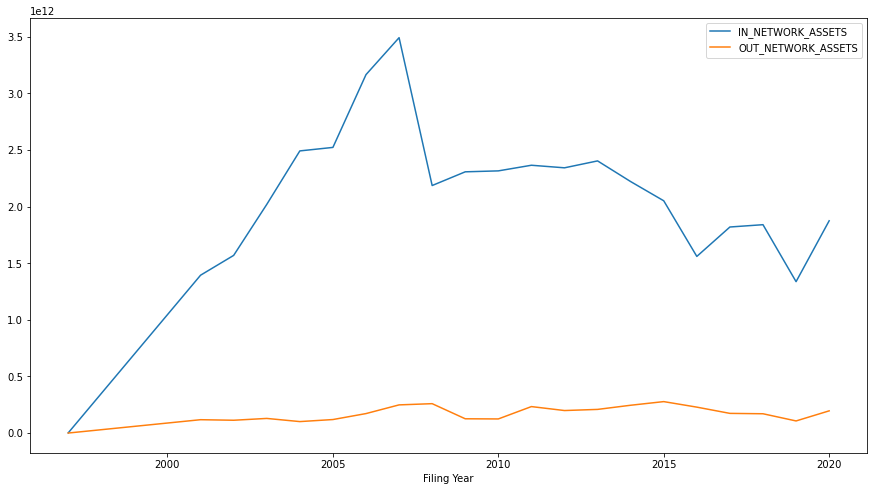

In [46]:
c.groupby('Filing Year')[['IN_NETWORK_ASSETS', 'OUT_NETWORK_ASSETS']].sum().plot(figsize=(15, 8))
plt.show()